In [1]:
import tensorflow.keras as keras
keras.__version__

"""
Allocate only as much GPU memory as needed for the runtime allocations.
"""
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Sequence processing with convnets

Convolutional neural networks perform particularly well on computer vision problems, due to their ability to operate convolutionally, `extracting features from local input patches and allowing for representation modularity and data efficiency`.

The same properties that make convnets excel at computer vision also make them highly relevant to `sequence processing`. (Time can be treated as a spatial dimension, like the height or width of a 2D image.) Such 1D convnets applied to sequence-processing is much cheaper. 

Recently, 1D convnets, typically used with dilated kernels, have been used with great success for `audio generation` and `machine translation`. In addition to these specific successes, it has long been known that small 1D convents can offer a fast alternative to RNNs for simple tasks such as `text classification` and `timeseries forecasting`.

## Understanding 1D convolution for sequence data

Convnets for image processing typically use 2D convolutions, extracing 2D patches from image tensors and applying an identical transformation to every patch.

1D convolutions, extracting local 1D patches (subsequences) from sequences, and recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations) For instance, a 1D convent processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence.

## Implementing a 1D convnet

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)   # split the training data into training+validation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

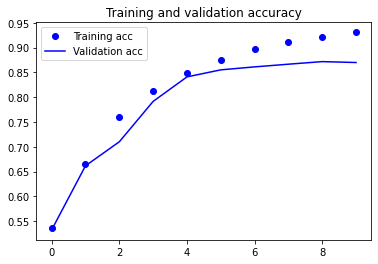

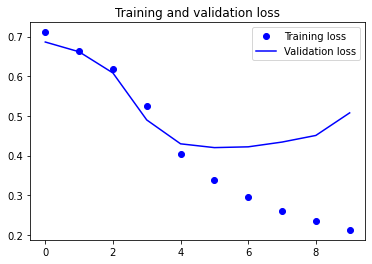

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a fairly weak way to induce order-sensitivity. 

Let's visualize this weakness by trying 1D convnets on the temperature forecasting problem from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

In [6]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# Re-do the temperature forecast with 1D convnet (aka convolutional layers + pooling layers)

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 0.4196 - val_loss: 0.4471
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3618 - val_loss: 0.4591
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3361 - val_loss: 0.4551
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3211 - val_loss: 0.4572
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3092 - val_loss: 0.4727
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2996 - val_loss: 0.4761
Epoch 7/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2904 - val_loss: 0.4541
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2834 - val_loss: 0.4751
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2792 - val_loss: 0.4710
Epoch 10/20
5

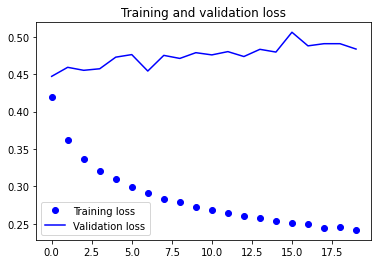

In [8]:
"""
Training and validation Mean Absolute Errors
"""

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation MAE stays in the low 0.40s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. towards the beginning, towards the end, etc.). `Since more recent datapoints should be interpreted differently from older datapoints in the case of this specific forecasting problem, (i.e., recent datapoints should weight more), the convnet fails at producing meaningful results here.` This limitation of convnets was not an issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently of where they are found in the input sentences.

`One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN.` This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we could either `look at data from further back (by increasing the lookback parameter of the data generator)`, or `look at high-resolution timeseries (by decreasing the step parameter of the generator)`. Here, we will chose (somewhat arbitrarily) to use a step twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one point per 30 minutes.

In [9]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [11]:
# New model -- two Conv1D layers and following-up with a GRU layer.

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 73s 145ms/step - loss: 0.3295 - val_loss: 0.2778
Epoch 2/20
50

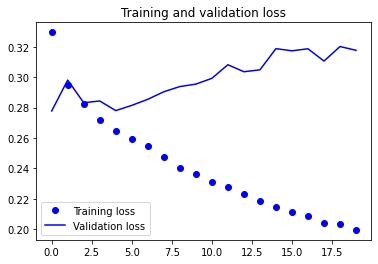

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Judging from the validation loss, this setup is not quite as good as the `regularized GRU` alone, but it's significantly faster. It is looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.
